In [2]:
# importing modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(22)
from math import sqrt
from datetime import datetime
import altair as alt

In [3]:
# wandb cell

# we have used the reports and graphs generateed in the wandb
# dashboard directly in the code as well as report.

!pip install wandb
import wandb

wandb.login()

# there are cells below all models we have trained that will log in the
# details of each run into the wandb dashboard

wandb: Currently logged in as: ck20 (use `wandb login --relogin` to force relogin)


True

In [4]:
# reading the dataset
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          426 non-null    object 
 1   new_cases     426 non-null    int64  
 2   total_cases   426 non-null    int64  
 3   active_cases  426 non-null    float64
 4   mobilty       426 non-null    float64
 5   dose1         426 non-null    int64  
 6   dose2         426 non-null    int64  
 7   new_deaths    426 non-null    int64  
 8   total_deaths  426 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 30.1+ KB


In [18]:
df.head()

,date,new_cases,total_cases,active_cases,mobilty,dose1,dose2,new_deaths,total_deaths
0,2020-02-11,1,1,1.0,109.07,0,0,0,0
1,2020-02-12,0,1,0.0,111.20,0,0,0,0
2,2020-02-13,0,1,0.0,110.18,0,0,0,0
3,2020-02-14,0,1,0.0,123.91,0,0,0,0
4,2020-02-15,0,1,0.0,131.79,0,0,0,0


## Data pre-processing

Most of the pre-processing was done at the time of scraping the data insdie their respective folders. The code is included withing the respective scrape files. Once all the data was collected, it was accumulated inside a "data.csv" file. Since the number of data points were relatively small, doing it like this instead of here was faster and more convinient

## Data visualization

Below we visualize all the features to get the feel of the trends and a high level overview of our dataset

We start with individual plots and then go on to build a combined plot using Altair library

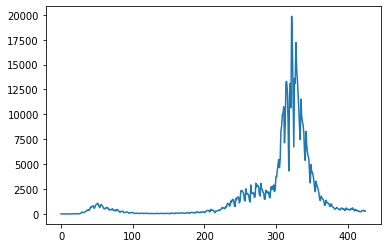

In [38]:
plt.plot(df['new_cases'])
plt.show()

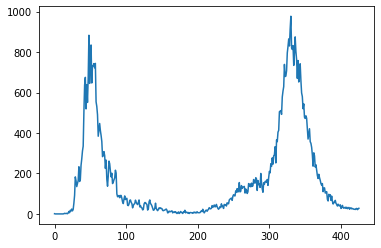

In [8]:
plt.plot(df['active_cases'])
plt.show()

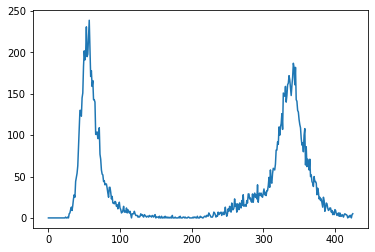

In [9]:
plt.plot(df['new_deaths'])
plt.show()

From the above two graphs, there seems to be a similarity b/w new deaths and active cases in London

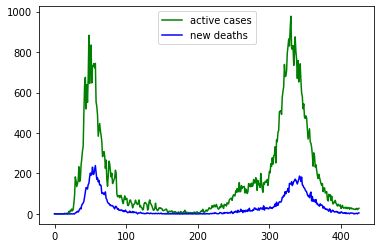

In [31]:
# plotting them together
fig, ax = plt.subplots()
ax.plot(df['active_cases'], 'g', label='active cases')
ax.plot(df['new_deaths'], 'b', label='new deaths')
leg = ax.legend()

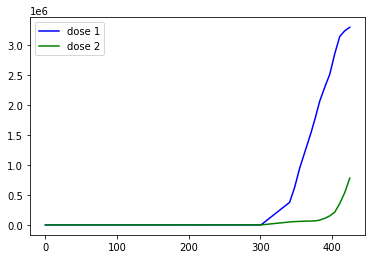

In [32]:
fig, ax = plt.subplots()
ax.plot(df['dose1'], 'b', label='dose 1')
ax.plot(df['dose2'], 'g', label='dose 2')
leg = ax.legend()

In [48]:
alt.Chart(df).mark_circle().encode(
    x='date:T',
    y='mobilty',
    size=alt.Size('mobilty',
        scale=alt.Scale(range=[0,500]),
        legend=alt.Legend(title='Daily mobilty')
    )
).properties(
    width=3000,
    height=300
)

alt.Chart(...)

In [20]:
interval = alt.selection_interval()
circle = alt.Chart(df).mark_circle().encode(
    x='date:O',
    size=alt.Size('new_cases:Q',
        scale=alt.Scale(range=[0, 3000]),
        legend=alt.Legend(title='Daily new cases')
    ) 
).properties(
    width=3000,
    height=300,
    selection=interval
)

bars = alt.Chart(df).mark_bar().encode(
    x='sum(new_cases):Q'
).properties(
    width=1000
).transform_filter(
    interval
)

circle & bars

alt.VConcatChart(...)

### Problem and our approach

We set out to identify the relationship b/w "new deaths" per day and "active cases" per day. We thouight we should be able to even use one to predict another. However, on the way, we realized, due the lack of data and even otherwise, we should also take cues for predicting new cases in future from the cases reported in previous few weeks. So the task of out model will be to be able to forcast upcoming cases in the area of London.

### SVR model

below cells are relating to SVR model

In [5]:
# creating a new dataset based on active cases since the past past 25 days
# and using them as features

date = df['date'].tolist()
new_cases = df['new_cases'].tolist()
mob = df['mobilty'].tolist()
dose1 = df['dose1'].tolist()
dose2 = df['dose2'].tolist()
new_deaths = df['new_deaths'].tolist()
active_cases = df['active_cases'].tolist()

n = len(date)
past = 25

X = np.zeros((n-past, 2*past+3))
y = np.zeros((n-past, 1))

for i in range(n-past):
    tmp = np.zeros(2*past+3)
    tmp[:past] = new_cases[i:i+past]
    tmp[past:2*past] = new_deaths[i:i+past]
    tmp[2*past] = mob[i+past]
    tmp[2*past+1] = dose1[i+past]
    tmp[2*past+2] = dose2[i+past]
    X[i] = tmp
    y[i] = active_cases[i+past]

cols = [f'cases_day_{i}' for i in range(1, past+1)]
cols += [f'deaths_day_{i}' for i in range(1, past+1)]
cols.append('mobility')
cols.append('dose1')
cols.append('dose2')

X = pd.DataFrame(X, columns=cols)
X['date'] = date[past:]
print(X.shape, y.shape)
print(X.head())

(401, 54) (401, 1)
   cases_day_1  cases_day_2  cases_day_3  ...  dose1  dose2        date
0          1.0          0.0          0.0  ...    0.0    0.0  2020-03-07
1          0.0          0.0          0.0  ...    0.0    0.0  2020-03-08
2          0.0          0.0          0.0  ...    0.0    0.0  2020-03-09
3          0.0          0.0          0.0  ...    0.0    0.0  2020-03-10
4          0.0          0.0          0.0  ...    0.0    0.0  2020-03-11

[5 rows x 54 columns]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# seperate out the dates
date_train = X_train['date']
X_train.drop(['date'], inplace=True, axis=1)
date_test = X_test['date']
X_test.drop(['date'], inplace=True, axis=1)

scx = StandardScaler()
scy = StandardScaler()
X_train_std = scx.fit_transform(X_train)
X_test_std = scx.transform(X_test)
y_train_std = scy.fit_transform(y_train)
y_test_std = scy.transform(y_test)

# reshaping the target vector y
y_train_std = np.squeeze(y_train_std)
y_test_std = np.squeeze(y_test_std)
print(X_train_std.shape, X_test_std.shape, y_train_std.shape, y_test_std.shape)

(300, 53) (101, 53) (300,) (101,)


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

reg = SVR()

param_grid = {
    'kernel': ['rbf', 'poly',],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 1.0],
    'tol': [1e-5, 1e-3, 0.005, 0.1],
    'C': [0.0001, 0.005, 0.01, 0.1, 1.0],
    'epsilon': [0.5, 0.1, 0.01, 0.001]
}

gridsearch = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error').fit(X_train_std, y_train_std)
print('Best score: ', gridsearch.best_score_, 'with params: ', gridsearch.best_params_)

Best score:  -0.19330863377415944 with params:  {'C': 1.0, 'coef0': 1.0, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly', 'tol': 0.1}


In [10]:
# training the SVR model

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# best params from GridSearch
# {'C': 1.0, 'coef0': 1.0, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly', 'tol': 0.1}
svr = SVR(kernel='poly', C=1.0, coef0=1.0, epsilon=0.01, tol=0.1, degree=3)
svr.fit(X_train_std, y_train_std)
y_pred = svr.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred))
print(rmse)

0.18561923489814047


In [11]:
# wandb log cell

proj = 'final_submission'
team_name = 'pct101'
run_name = 'SVR'
wandb.init(project=proj, entity=team_name, name=run_name)

wandb.sklearn.plot_regressor(svr, X_train_std, X_test_std, y_train_std, y_test_std,  model_name=run_name)

_runtime,5
_timestamp,1619780625
_step,1


_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: 
wandb: Plotting SVR.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


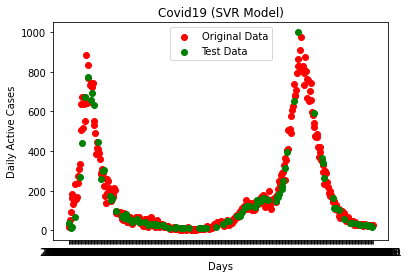

In [61]:
# plot the regression fit with original data
y_pred_plt = np.array(scy.inverse_transform(y_pred))
y_pred_plt = y_pred_plt.reshape((-1, 1))
y_test_std = y_test_std.reshape((-1, 1))
y_train_std = y_train_std.reshape((-1, 1))
y_plt = y.reshape((-1, 1))

plt.scatter(date[past:], y_plt, color = 'red', label = 'Original Data')
plt.scatter(date_test.values, y_pred_plt, color = 'green', label = 'Test Data')
plt.title('Covid19 (SVR Model)')
plt.xlabel('Days')
plt.ylabel('Daily Active Cases')
plt.legend()
plt.show()

Results for Linear Regression model (should be pretty close to SVR model)
0.2505988381296822
0.9056003052320223
Feature: 0, Score: 0.18458
Feature: 1, Score: 0.05793
Feature: 2, Score: 0.04655
Feature: 3, Score: -0.18843
Feature: 4, Score: 0.02989
Feature: 5, Score: -0.07388
Feature: 6, Score: 0.04596
Feature: 7, Score: -0.15832
Feature: 8, Score: -0.01223
Feature: 9, Score: 0.01980
Feature: 10, Score: 0.02614
Feature: 11, Score: 0.11574
Feature: 12, Score: -0.01197
Feature: 13, Score: -0.13332
Feature: 14, Score: -0.00010
Feature: 15, Score: -0.06085
Feature: 16, Score: 0.05096
Feature: 17, Score: -0.03231
Feature: 18, Score: 0.01941
Feature: 19, Score: 0.10889
Feature: 20, Score: 0.09709
Feature: 21, Score: 0.06997
Feature: 22, Score: 0.08176
Feature: 23, Score: 0.07441
Feature: 24, Score: 0.02581
Feature: 25, Score: -0.14334
Feature: 26, Score: 0.01907
Feature: 27, Score: -0.05211
Feature: 28, Score: 0.18211
Feature: 29, Score: 0.05971
Feature: 30, Score: 0.11146
Feature: 31, Score:

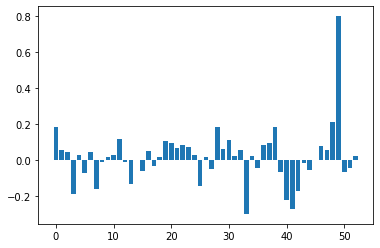

In [62]:
# extracting feature importance
# NOTE: We cannot extract feature importance from a SRV model since the feautures
# in it are transformed to another plane and hence are modified before prediction.
# Hence we make use of a "Linear Regression" model

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_std, y_train_std)
y_pred_fi = reg.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred_fi))
print('Results for Linear Regression model (should be pretty close to SVR model)')
print(rmse)
print(reg.score(X_test_std, y_test_std))

# summarize feature importance
importance = reg.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Clearly as can be seen, the most important feature is in fact previous day death count. The other features have comparatively lesser importance in the prediction of current days active cases

### 2-layered NN model

Below cells are related to the 2-layers NN model

In [14]:
import torch

X_train_nn = torch.from_numpy(X_train_std.astype(np.float32)).view(300, 53)
X_test_nn = torch.from_numpy(X_test_std.astype(np.float32)).view(101, 53)
y_train_nn = torch.from_numpy(y_train_std.astype(np.float32)).view(300,1)
y_test_nn = torch.from_numpy(y_test_std.astype(np.float32)).view(101,1)

In [16]:
min_loss=1000
layer = 80 #159 mse loss = 0.1589 on test set and 0.018 on train set; 106 mse loss 0.1465 on test set and 0.019 on train
epochs = 40000

modelx = torch.nn.Sequential(
    torch.nn.Linear(53, layer),
    torch.nn.ReLU(),
    torch.nn.Linear(layer, layer),
    torch.nn.ReLU(),
    torch.nn.Linear(layer, 1),
)
loss_fn = torch.nn.MSELoss()
wandb.watch(modelx, log_freq=100)

learning_rate = 1e-3
optimizer = torch.optim.RMSprop(modelx.parameters(), lr=learning_rate)

start_time = datetime.now()

for t in range(epochs):
    y_pred = modelx(X_train_nn)

    RMSE_loss = torch.sqrt(loss_fn(y_pred, y_train_nn))
    
    optimizer.zero_grad()

    RMSE_loss.backward()

    optimizer.step()

    if t%100 == 99:
        print(t+1, RMSE_loss.item())
        wandb.log({"loss": RMSE_loss})

y1_pred = modelx(X_test_nn).detach()
print(y1_pred.shape)
y1_pred_plt = np.array(scy.inverse_transform(y1_pred))
y1_pred_plt = y1_pred_plt.reshape((-1, 1))
y1_plt = df['active_cases'].values.reshape((-1, 1))
print(torch.sqrt(loss_fn(y1_pred, y_test_nn)))

100 0.13567255437374115
200 0.12190850079059601
300 0.11319280415773392
400 0.11491089314222336
500 0.09625446796417236
600 0.08769796788692474
700 0.08242027461528778
800 0.08510065823793411
900 0.08172937482595444
1000 0.07882966101169586
1100 0.07501865923404694
1200 0.06955428421497345
1300 0.06868876516819
1400 0.05864792689681053
1500 0.06353294849395752
1600 0.06382618844509125
1700 0.058832570910453796
1800 0.05998587608337402
1900 0.046548474580049515
2000 0.06072201952338219
2100 0.06906705349683762
2200 0.05178479477763176
2300 0.04890936613082886
2400 0.05505046620965004
2500 0.05532480403780937
2600 0.05150727555155754
2700 0.05887898802757263
2800 0.04858173802495003
2900 0.05054011940956116
3000 0.04999423027038574
3100 0.048561085015535355
3200 0.05621591955423355
3300 0.05028260126709938
3400 0.04428886994719505
3500 0.046266332268714905
3600 0.046640411019325256
3700 0.04830373823642731
3800 0.04499369114637375
3900 0.04403931275010109
4000 0.047912586480379105
4100 0

### Other models we tried

Below cells include other models that we gave a spin. These include: **LinearRegression** model and **Prophet** model

#### Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_std, y_train_std)
y_pred = reg.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred))
print(rmse)
print(reg.score(X_test_std, y_test_std))

0.2505988381296822
0.9056003052320223


In [13]:
# wandb log cell

proj = 'final_submission'
team_name = 'pct101'
run_name = 'LR'
wandb.init(project=proj, entity=team_name, name=run_name)

wandb.sklearn.plot_regressor(reg, X_train_std, X_test_std, y_train_std, y_test_std,  model_name=run_name)

_runtime,7
_timestamp,1619780864
_step,3


_runtime,▁▅▆█
_timestamp,▁▅▆█
_step,▁▃▆█


wandb: 
wandb: Plotting LR.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


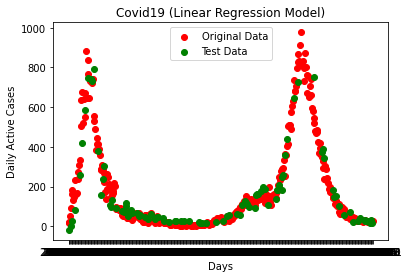

In [72]:
# plot the regression fit with original data
y_pred_plt = np.array(scy.inverse_transform(y_pred))
y_pred_plt = y_pred_plt.reshape((-1, 1))
y_test_std = y_test_std.reshape((-1, 1))
y_train_std = y_train_std.reshape((-1, 1))
y_plt = y.reshape((-1, 1))

plt.scatter(date[past:], y_plt, color = 'red', label = 'Original Data')
plt.scatter(date_test.values, y_pred_plt, color = 'green', label = 'Test Data')
plt.title('Covid19 (Linear Regression Model)')
plt.xlabel('Days')
plt.ylabel('Daily Active Cases')
plt.legend()
plt.show()

#### Prophet

In [67]:
from fbprophet import Prophet

new_df = df[['date', 'total_cases']]
new_df.columns = ['ds', 'y']

model = Prophet(interval_width=0.95)
model.fit(new_df)
future = model.make_future_dataframe(periods=90)

forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds           yhat     yhat_lower    yhat_upper
511 2021-07-06  855582.116280  510810.812641  1.211793e+06
512 2021-07-07  857042.415886  510437.870195  1.217942e+06
513 2021-07-08  858319.654380  497396.656355  1.230059e+06
514 2021-07-09  859366.779165  485803.624695  1.242462e+06
515 2021-07-10  860514.912645  491245.865626  1.243649e+06


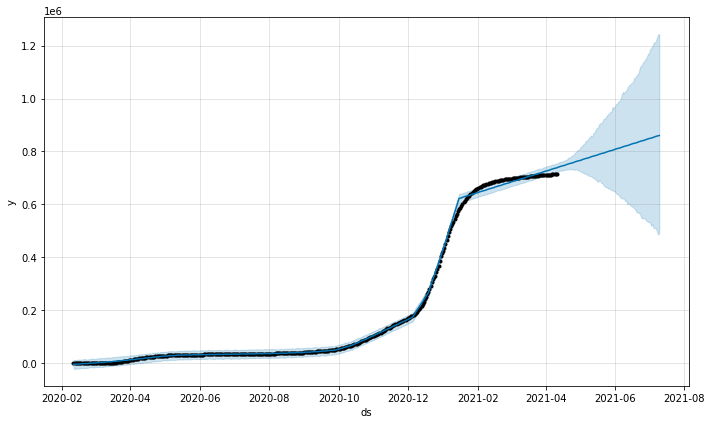

In [68]:
confirmed_forecast_plot = model.plot(forecast)

The total cases as seen from the Prophet model will grimly continue to rise althouth at a far lower rate

In [69]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)